# Spaceship Titanic EDA

*Spaceship Titanic*

Predict which passengers are transported to an alternate dimension

*Evaluation*

Classification Accuracy 

## Packages & Imports 

In [1]:
using Pkg
Pkg.status() # Installed Packages

Status `C:\Users\Utsav\Utsav\Development\Julia\SpaceshipTitanic\Project.toml`


  [024491cd] BetaML v0.9.6
  [336ed68f] CSV v0.10.9
  [a93c6f00] DataFrames v1.5.0
  [31c24e10] Distributions v0.25.86
  [5789e2e9] FileIO v1.16.0
  [7073ff75] IJulia v1.24.0
  [82e4d734] ImageIO v0.6.6
  [6218d12a] ImageMagick v1.2.2
  [916415d5] Images v0.25.2
  [add582a8] MLJ v0.19.1
⌃ [91a5bcdd] Plots v1.38.6
  [d330b81b] PyPlot v2.11.1
  [f3b207a7] StatsPlots v0.15.4
  [239c3e63] Vega v2.3.1
  [6385f0a0] WordCloud v0.10.8
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
# Necessary Imports

using CSV
using DataFrames
using Plots
using Plots.PlotMeasures
using StatsPlots
using WordCloud
using Images, FileIO
using Vega
using Statistics

## Data Loading 

Column Descriptions : 
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Target Descriptions : 
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


In [3]:
# Config

BASE_PATH = "../data"
TRAIN_PATH = "$BASE_PATH/train.csv"
TEST_PATH = "$BASE_PATH/test.csv"
SUB_PATH = "$BASE_PATH/sample_submission.csv"

"../data/sample_submission.csv"

In [4]:
train_csv = CSV.File(TRAIN_PATH; header=1,delim=',')
train_df = DataFrame(train_csv)
test_df = CSV.File(TEST_PATH) |> DataFrame
sub_df = CSV.File(SUB_PATH) |> DataFrame
print("Done!")

Done!

`Exploring Train DataFrame`

In [5]:
first(train_df,5)

Row,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
,String7,String7?,Bool?,String15?,String15?,Float64?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,String31?,Bool
1,0001_01,Europa,false,B/0/P,TRAPPIST-1e,39.0,false,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,false
2,0002_01,Earth,false,F/0/S,TRAPPIST-1e,24.0,false,109.0,9.0,25.0,549.0,44.0,Juanna Vines,true
3,0003_01,Europa,false,A/0/S,TRAPPIST-1e,58.0,true,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,false
4,0003_02,Europa,false,A/0/S,TRAPPIST-1e,33.0,false,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,false
5,0004_01,Earth,false,F/1/S,TRAPPIST-1e,16.0,false,303.0,70.0,151.0,565.0,2.0,Willy Santantines,true


In [6]:
println("Column Wise Missing Values :")
sort(describe(train_df,:nmissing),[:nmissing],rev=true)

Column Wise Missing Values :


Row,variable,nmissing
,Symbol,Int64
1,CryoSleep,217
2,ShoppingMall,208
3,VIP,203
4,HomePlanet,201
5,Name,200
6,Cabin,199
7,VRDeck,188
8,FoodCourt,183
9,Spa,183


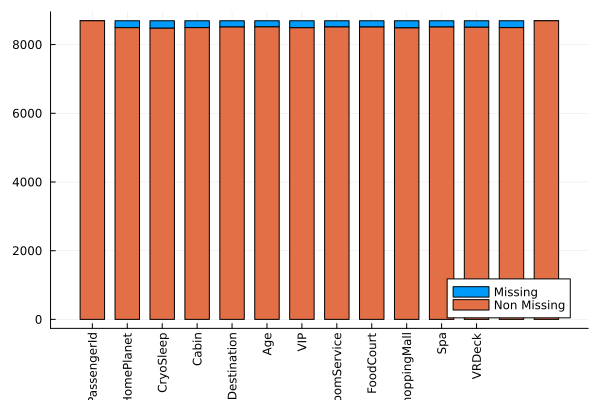

In [7]:
train_df_missing_stats = describe(train_df,:nmissing,:nnonmissing)
ticklabel = train_df_missing_stats[!,:variable]
groupedbar(Matrix(select(train_df_missing_stats,Not(:variable))),
        bar_position = :stack,
        bar_width=0.7,
        xticks=(1:12, ticklabel),
        xrotation = 90,
        label=["Missing" "Non Missing" ])

In [8]:
stats = [:std, :min, :q25, :median, :q75, :max, :nunique]
describe(train_df,stats...)

Row,variable,std,min,q25,median,q75,max,nunique
,Symbol,Union…,Any,Union…,Union…,Union…,Any,Union…
1,PassengerId,,0001_01,,,,9280_02,8693
2,HomePlanet,,Earth,,,,Mars,3
3,CryoSleep,0.479531,false,0.0,0.0,1.0,true,
4,Cabin,,A/0/P,,,,T/3/P,6560
5,Destination,,55 Cancri e,,,,TRAPPIST-1e,3
6,Age,14.489,0.0,19.0,27.0,38.0,79.0,
7,VIP,0.151303,false,0.0,0.0,0.0,true,
8,RoomService,666.718,0.0,0.0,0.0,47.0,14327.0,
9,FoodCourt,1611.49,0.0,0.0,0.0,76.0,29813.0,


`Exploring Test DataFrame`

In [9]:
first(test_df,5)

Row,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
,String7,String7?,Bool?,String15?,String15?,Float64?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,String31?
1,0013_01,Earth,true,G/3/S,TRAPPIST-1e,27.0,false,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
2,0018_01,Earth,false,F/4/S,TRAPPIST-1e,19.0,false,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
3,0019_01,Europa,true,C/0/S,55 Cancri e,31.0,false,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
4,0021_01,Europa,false,C/1/S,TRAPPIST-1e,38.0,false,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
5,0023_01,Earth,false,F/5/S,TRAPPIST-1e,20.0,false,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [10]:
println("Column Wise Missing Values :")
sort(describe(test_df,:nmissing),[:nmissing],rev=true)

Column Wise Missing Values :


Row,variable,nmissing
,Symbol,Int64
1,FoodCourt,106
2,Spa,101
3,Cabin,100
4,ShoppingMall,98
5,Name,94
6,CryoSleep,93
7,VIP,93
8,Destination,92
9,Age,91


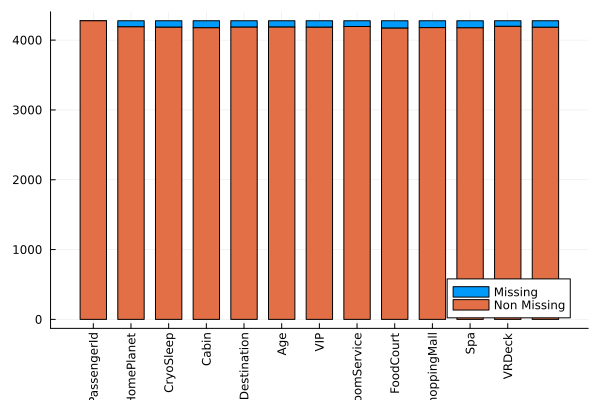

In [11]:
test_df_missing_stats = describe(test_df,:nmissing,:nnonmissing)
ticklabel = test_df_missing_stats[!,:variable]
groupedbar(Matrix(select(test_df_missing_stats,Not(:variable))),
        bar_position = :stack,
        bar_width=0.7,
        xticks=(1:12, ticklabel),
        xrotation = 90,
        label=["Missing" "Non Missing" ])

In [12]:
stats = [:std, :min, :q25, :median, :q75, :max, :nunique]
describe(test_df,stats...)

Row,variable,std,min,q25,median,q75,max,nunique
,Symbol,Union…,Any,Union…,Union…,Union…,Any,Union…
1,PassengerId,,0013_01,,,,9277_01,4277
2,HomePlanet,,Earth,,,,Mars,3
3,CryoSleep,0.482598,false,0.0,0.0,1.0,true,
4,Cabin,,A/1/P,,,,T/4/P,3265
5,Destination,,55 Cancri e,,,,TRAPPIST-1e,3
6,Age,14.1791,0.0,19.0,26.0,37.0,79.0,
7,VIP,0.131825,false,0.0,0.0,0.0,true,
8,RoomService,607.011,0.0,0.0,0.0,53.0,11567.0,
9,FoodCourt,1527.66,0.0,0.0,0.0,78.0,25273.0,


`Submission File`

In [13]:
first(sub_df,5)

Row,PassengerId,Transported
,String7,Bool
1,0013_01,false
2,0018_01,false
3,0019_01,false
4,0021_01,false
5,0023_01,false


## EDA

In [14]:
select!(train_df,Not(:PassengerId))
select!(test_df,Not(:PassengerId))
TARGET = "Transported"
FEATURES = names(train_df)
FEATURES = FEATURES[FEATURES .!= TARGET]
select!(train_df,FEATURES)
RANDOM_STATE = 42 

42

`Null Value Distribution`

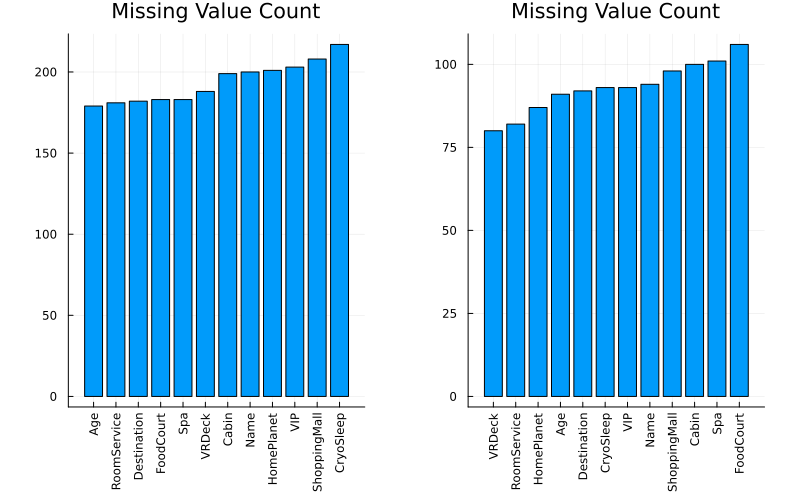

In [15]:
plots = []

train_missing = sort(describe(train_df,:nmissing),:nmissing)
test_missing = sort(describe(test_df,:nmissing),:nmissing)
train_missing

y = map(x -> String(x),train_missing[!,:variable])
x = train_missing[!,:nmissing]
p = bar(y,x,xrotation=90,legend=false)
push!(plots,p)

y = map(x -> String(x),test_missing[!,:variable])
x = test_missing[!,:nmissing]
p = bar(y,x,xrotation=90,legend=false)
push!(plots,p)

p = plot(plots...,size=(800,500),title="Missing Value Count",margin=7mm,top_margin=2mm)
p

`Categorical & Continous Data Distribution`

Total Number of Features: 12
Number of Categorical Features: 4
Number of Continuos Features: 6
Number of Text Features: 2


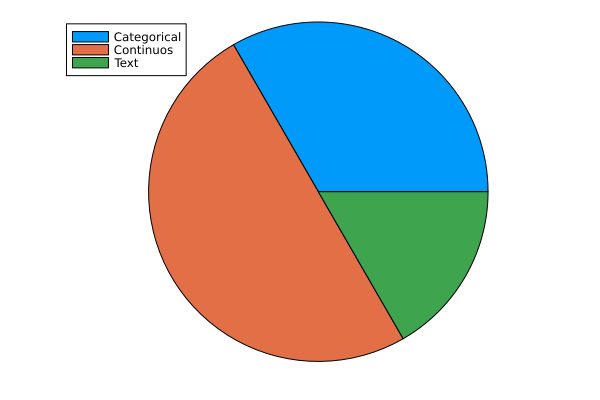

In [16]:
text_features = ["Cabin","Name"]
cat_features = []
cont_features = []
nuniques = Dict(map(x -> (x , size(unique(train_df,x),1)),names(train_df)))

for col in FEATURES 
    if (col in text_features) == false
        if nuniques[col] < 25 
            push!(cat_features,col)
        else
            push!(cont_features,col)
        end
    end
end

println("Total Number of Features: $(length(FEATURES))")
println("Number of Categorical Features: $(length(cat_features))")
println("Number of Continuos Features: $(length(cont_features))")
println("Number of Text Features: $(length(text_features))")
# println(text_features)
# println(cat_features)
# println(cont_features)

feat_name = ["Categorical","Continuos","Text"]
feat_count = [length(cat_features),length(cont_features),length(text_features)]

pie(feat_name, feat_count,)

`Age Feature`

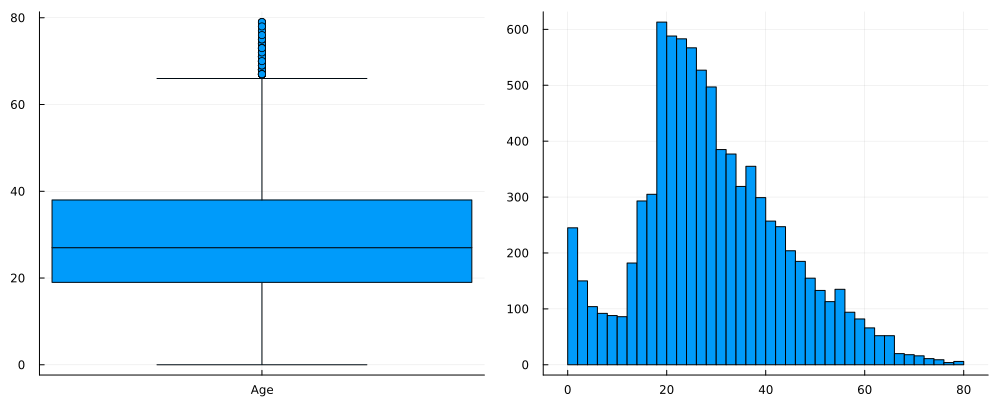

In [17]:
plots = []
ages = train_df[!,:Age][train_df[!,:Age] .!== missing]
p = boxplot(repeat(["Age"],outer=size(ages,1)),ages,size=(150,400),legend=false)
push!(plots,p)

p = histogram(ages,legend=false)
push!(plots,p)

plot(plots...,size=(1000,400))

In [36]:
cont_features
plots = []

for feat in cat_features 
    function count_values(df) 
        all_vals = df[!,feat]
        vals = all_vals[all_vals .!== missing]
        uniq_vals = unique(vals)
        counts = []
        # println("$feat => $uniq_vals")
        for uniq_val in uniq_vals 
            temp = vals[vals .== uniq_val]
            # println("$uniq_val ~> $(length(temp))")
            push!(counts,length(temp))
        end
        # println("")
        uniq_vals, counts
    end


    ticklabels,train_count = count_values(train_df)
    ticklabels,test_count = count_values(test_df)
    # println(feat)
    # println(ticklabels)
    # println(train_count)
    # println(test_count)
    # println("")

    
    p = groupedbar([train_count test_count],
        bar_position=:stack,
        bar_width=0.7,
        xticks=ticklabels,
        label=["train" "test"],
        title=feat)
    push!(plots,p)
end

plot(plots...,layout=(2,2),size=(800,800))


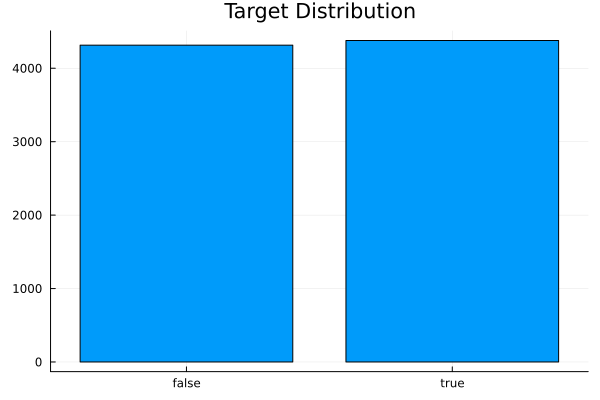

In [20]:
target_val = DataFrame(CSV.File(TRAIN_PATH))[!,TARGET]
counts = [sum(target_val .== false),sum(target_val .== true)]
bar(["false","true"],counts,title="Target Distribution",legend=false)

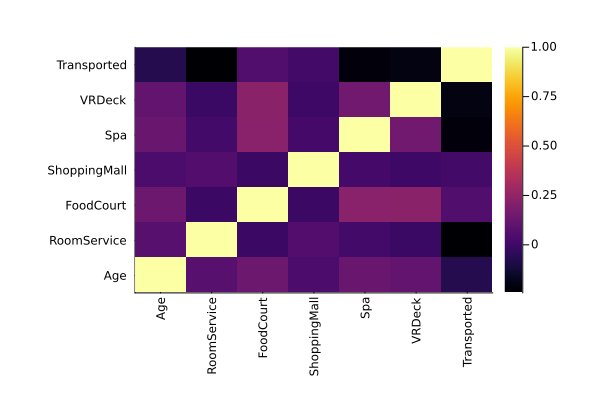

In [21]:
full_train_df = CSV.File(TRAIN_PATH) |> DataFrame 
select!(full_train_df, [cont_features...,TARGET])
full_train_df = full_train_df[completecases(full_train_df), :]

all_features = names(full_train_df)
heatmap(all_features,all_features,cor(Matrix(full_train_df)),xrotation=90,margin=10mm)
# xticks!(1:7,all_features)
# yticks!(1:7,all_features)

In [22]:
DataFrame(cor(Matrix(full_train_df)),all_features)

Row,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0672147,0.131877,0.0325285,0.123957,0.103424,-0.0765357
2,0.0672147,1.0,-0.0156592,0.0548979,0.011651,-0.0188695,-0.243335
3,0.131877,-0.0156592,1.0,-0.013888,0.223261,0.224416,0.0510971
4,0.0325285,0.0548979,-0.013888,1.0,0.0144415,-0.00445139,0.00835593
5,0.123957,0.011651,0.223261,0.0144415,1.0,0.144365,-0.221511
6,0.103424,-0.0188695,0.224416,-0.00445139,0.144365,1.0,-0.207
7,-0.0765357,-0.243335,0.0510971,0.00835593,-0.221511,-0.207,1.0
